In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/dummy.csv')
last_day = pd.DataFrame(df.iloc[-1 :])
last_day['Date'] = pd.to_datetime(last_day['Date']) + pd.Timedelta(days=1)
df = pd.concat([df, last_day], axis = 0)
df.reset_index(drop = True, inplace = True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1230,2021-11-02,228.000000,235.000000,227.250000,228.500000,228.500000,91597155
1231,2021-11-03,230.000000,230.899994,226.199997,228.800003,228.800003,49974804
1232,2021-11-04,231.800003,233.149994,230.600006,231.350006,231.350006,14860447
1233,2021-11-08,233.000000,235.649994,228.750000,234.550003,234.550003,53847194
1234,2021-11-09 00:00:00,233.000000,235.649994,228.750000,234.550003,234.550003,53847194


[]

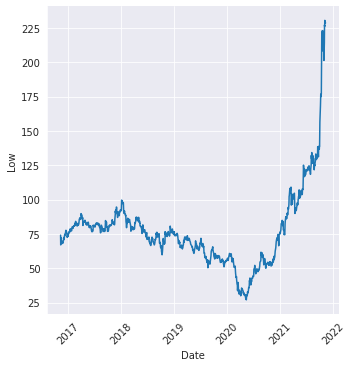

In [ ]:
df_close = pd.DataFrame(df['Low'])
df_close.index = pd.to_datetime(df['Date'])
df_close.head()

sns.relplot(x='Date',y='Low', kind='line',data=df_close)
plt.xticks(rotation=45)
plt.plot()

Auto Correlation Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


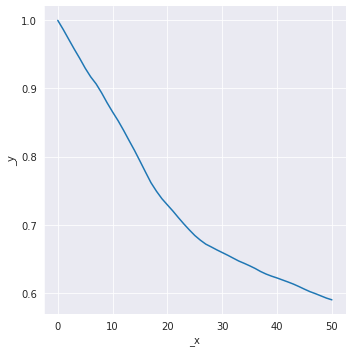

In [ ]:
from statsmodels.tsa import stattools
acf,_,_,_ = stattools.acf(df_close,unbiased=True,nlags=50,qstat=True,fft=True,alpha = 0.05)
#acf is a numpy ndarray
sns.set_style("darkgrid")
sns.relplot(pd.Series(acf).index, pd.Series(acf).values, kind='line')

In [ ]:
# list_of_previous_t_instants = [i for i in range(1,16)]
# list_of_previous_t_instants.sort()
# #print(list_of_previous_t_instants)
# start = list_of_previous_t_instants[-1]
# end = len(df_close)
# #print(start,end)
# attribute = ['Close']

# df_close['Date'] = df_close.index


# column = df_close.iloc[start : end]         #It keeps 'Date' column which will be used as an Index later 
# column.reset_index(drop=True, inplace=True)

# for feature in attribute:
#   previous_days_record_df = pd.DataFrame()

#   for time in list_of_previous_t_instants:  #15 Instances from auto-correlation function
#     new_column = df_close[feature].iloc[(start - time) : (end-time)]
    
#     new_column.reset_index(drop=True, inplace=True) #Very Important Before concatenation; Drop removes the Index column

#     previous_days_record_df = pd.concat([previous_days_record_df,new_column], axis=1)
#     previous_days_record_df.rename(columns = {feature : '{}-{}'.format(feature,time)}, inplace=True)

#   column = pd.concat([column,previous_days_record_df], axis = 1)
# column.set_index(['Date'], drop=True, inplace=True) #Drop = True makes sure to drop the column which is being used as index.
# #column.head()
# #column.shape
# print(column)

In [ ]:
df_close.head()

n_past = 8
n_future = 1

def prepare_data(dataframe, n_past, n_future):

  X, Y = list(), list()

  end = len(dataframe)
  for window in range(end):
    past_end = window + n_past 
    future_end = past_end + n_future

    if (future_end > end):
      break
    past_data, future_data = dataframe[window:past_end ], dataframe[past_end:future_end]
    # print(len(dataframe[window:past_end]))
    # print(type(dataframe))
    X.append(past_data)
    Y.append(future_data)

  return (np.array(X), np.array(Y))

X_Data, Y_Data = prepare_data(df_close.values, n_past, n_future)

In [ ]:
print(X_Data.shape)
print(Y_Data.shape)
#print(X_Data)

#Why Sqeeze? 

X_Data = np.squeeze(X_Data)
Y_Data = np.squeeze(Y_Data)


print(X_Data.shape)
print(Y_Data.shape)

**SPLIT DATASET**

In [ ]:
test_split = 0.10

X_Train, Y_Train = X_Data[:int(np.floor((1-test_split)*len(X_Data)))],Y_Data[:int(np.floor((1-test_split)*len(Y_Data)))]
X_Test, Y_Test  = X_Data[int(np.floor((1-test_split)*len(X_Data))):], Y_Data[int(np.floor((1-test_split)*len(Y_Data))) :]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Target_Scalar = MinMaxScaler(feature_range=(0.01,0.99))
Feature_Scalar = MinMaxScaler(feature_range=(0.01,0.99))

X_Train = Feature_Scalar.fit_transform(X_Train)
X_Test =  Feature_Scalar.fit_transform(X_Test)

Y_Train = Target_Scalar.fit_transform(np.reshape(Y_Train,(-1,1))) #fit_transform needs 2-D Array. Hence Resape.
Y_Test =  Target_Scalar.fit_transform(np.reshape(Y_Test ,(-1,1)))

#Currently, our data is in the form: [samples, features]
#and we are framing the problem as 15 time step for each sample.
#reshape input to be [samples, time steps, features]

X_Train = np.reshape(X_Train, (X_Train.shape[0],  X_Train.shape[1], 1))
X_Test =  np.reshape(X_Test, (X_Test.shape[0], X_Test.shape[1], 1))

#print(X_Train)

In [ ]:
print(X_Train.shape)

(1214, 8, 1)


**Model Architecture: Input of a LSTM's shape (n_timesteps x n_features). Here n_timesteps =15 i.e.
i.e. previous 15 day's data to predict next day's price and n_features =1 because Closing Price is the only feature here.**

In [ ]:
%tensorflow_version 1.x
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, Activation
from keras.layers import LSTM

n_timesteps = X_Train.shape[1]
n_features  = X_Train.shape[2]

print(n_timesteps, n_features)

# input_layer = (n_timesteps, n_features)

# look_back = n_timesteps

# # create and fit the LSTM network
# # model = Sequential()

# model = Sequential()
# model.add(LSTM(25, input_shape=(n_timesteps, n_features)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_Train, Y_Train, epochs=30, batch_size=16, verbose=1, 
#           validation_split = 0.2, shuffle=True)

8 1


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
input_layer = (n_timesteps, n_features)
model = Sequential()

model.add(Conv1D(filters=32,kernel_size=3,strides=1,activation='relu',padding='same', input_shape=input_layer ))
model.add(Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same' ))

#model.add(LSTM(25, return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')
model_checkpoint = ModelCheckpoint('Bit_Coin.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit(X_Train, Y_Train, epochs=30, batch_size=16, verbose=1, 
          validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 8, 32)             128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 8, 64)             6208      
_________________________________________________________________
lstm_15 (LSTM)               (None, 25)                9000      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 15,362
Trainable params: 15,362
Non-trainable params: 0
_________________________________________________________________
Train on 883 samples, validate on 221 samples
Epoch 1/30
883/883 [==============================] - 2s 2ms/step - loss: 0.0250 - val_loss: 0.0042

Epoch 00001: val_loss improved from inf to 0.00417, saving model to Bit_Coin.hdf5
Epoch 2/30
883/883

In [ ]:
Y_Predict = model.predict(X_Test)

Y_Predict_rescaled = Target_Scalar.inverse_transform(Y_Predict)

Y_Actual_rescaled = Target_Scalar.inverse_transform(Y_Test)  #In order to Nullify the minimax Normalization

Y_Actual  = pd.DataFrame(Y_Actual_rescaled, columns=['Actual_Value'])
Y_predict = pd.DataFrame(Y_Predict_rescaled, columns=['Predicted_Value'])

In [ ]:
Y_Actual.head()

[]

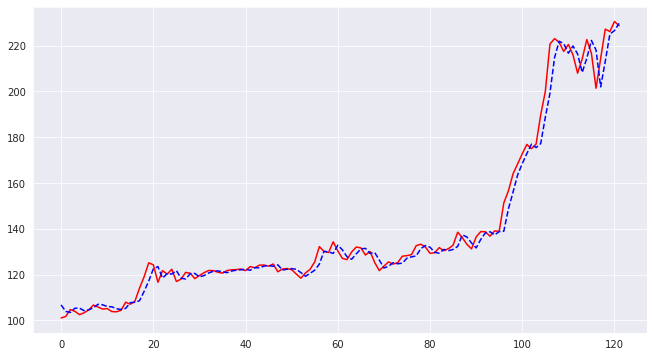

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(Y_Actual[:-1], linestyle='solid', color='r')
plt.plot(Y_predict[:-1], linestyle='dashed', color='b')
plt.plot()

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(Y_Actual[:-1], Y_predict[:-1])
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.9821


In [ ]:
# print('Next Day Actual {}'.format(list(Y_Actual.values)[-1]))
print('Next Day Prediction {}'.format(list(Y_predict.values)[-1]))

Next Day Prediction [228.96811]


Close 656.68; Low = 646.56; Highest: 659.23
